# Naive Bayes

In [1]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
TRAIN_DATA_FILEPATH = "../../pipeline_data/2019_thru_2021/train.parquet"
EVAL_DATA_FILEPATH = "../../pipeline_data/2019_thru_2021/eval.parquet"
TEST_DATA_FILEPATH = "../../pipeline_data/2019_thru_2021/test.parquet"

In [3]:
train_data = pd.read_parquet(TRAIN_DATA_FILEPATH)
eval_data = pd.read_parquet(EVAL_DATA_FILEPATH)
test_data = pd.read_parquet(TEST_DATA_FILEPATH)

In [4]:
X_test = test_data.drop("IS_CRASH", axis=1)
y_test = test_data.IS_CRASH

In [5]:
train_data.head()

,EVENT_DATE,EVENT_TIME,IS_CRASH,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,...,primary,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link
2081026,340,31235.682,False,10.316250,2025.50,0.000127,0.0,0.417391,46.214286,31.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13892716,158,61315.748,False,8.181429,1558.00,0.404432,0.0,0.000000,84.214286,66.928571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11934664,333,83997.996,False,11.715000,521.50,0.000260,0.0,0.000000,45.500000,24.142857,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
8636938,172,62606.920,False,10.065000,1303.50,0.647500,0.0,0.000000,79.076923,64.928571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4407752,221,57980.122,False,6.598750,1176.75,0.120588,0.0,0.000000,85.428571,66.785714,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## First model
First, let's fit a Gaussian Naive Bayes on all of the training data and evaluate performance

In [6]:
gnb = GaussianNB()

In [7]:
X = train_data.drop("IS_CRASH", axis=1)
y = train_data.IS_CRASH

In [8]:
gnb.fit(X, y)

GaussianNB()

In [9]:
X_eval = eval_data.drop("IS_CRASH", axis=1)

In [10]:
y_pred = gnb.predict(X_eval)

In [11]:
y_eval = eval_data.IS_CRASH
print("Number of mislabeled points out of a total %d points : %d" % (X_eval.shape[0], (y_eval != y_pred).sum()))

Number of mislabeled points out of a total 4558995 points : 24035


In [12]:
(y_eval == y_pred).sum() / X_eval.shape[0]

0.9947280047466601

In [13]:
y_pred_proba = gnb.predict_proba(X_eval)

In [14]:
y_pred_proba.shape

(4558995, 2)

In [15]:
roc_auc_score(y_eval, y_pred_proba[:, 1])

0.6573474725995916

In [16]:
(y == gnb.predict(X)).sum() / X.shape[0]

0.9947035837725627

In [17]:
roc_auc_score(y, gnb.predict_proba(X)[:, 1])

0.6455721931880204

In [18]:
len(y[y==1]) / len(y)

0.0001438182570075391

In [19]:
len(y_eval[y_eval==1]) / len(y_eval)

0.00015507803803250497

In [20]:
# [
#     [tn, fp,],
#     [fn, tp]
# ]
confusion_matrix(y_eval, y_pred)

array([[4534941,   23347],
       [    688,      19]])

In [21]:
confusion_matrix(y, gnb.predict(X))

array([[13604503,    70514],
       [    1925,       42]])

In [22]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba[:, 1])

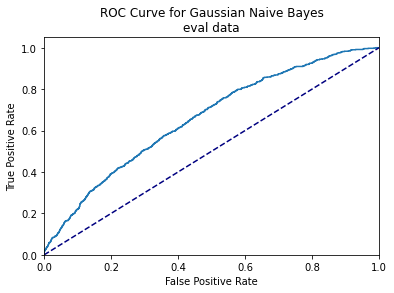

In [23]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve for Gaussian Naive Bayes\neval data")
plt.show()

In [24]:
y_pred_proba = gnb.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba[:, 1])

0.6393970568799929

### Analysis
We can see here that we don't appear to be overfitting, which is good. The accuracies and ROC-AUC scores on the training and eval data are quite similar. The accuracy probably isn't a helpful metric, since the distribution of the target is fairly skewed. We can try removing/combining some columns of our data to see how that impacts our performance.

## Second model
Let's start by simplifying the road types and see what happens

In [25]:
train_data.columns

Index(['EVENT_DATE', 'EVENT_TIME', 'IS_CRASH', 'AWND', 'PGTM', 'PRCP', 'SNOW',
       'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
       'WT06', 'WT08', 'WT09', 'WT10', 'WT11', 'WT13', 'WT14', 'WT15', 'WT16',
       'WT18', 'WT19', 'WT22', 'residential', 'service', 'secondary',
       'primary', 'cycleway', 'unclassified', 'trunk', 'pedestrian',
       'tertiary', 'path', 'secondary_link', 'living_street', 'primary_link'],
      dtype='object')

In [26]:
busy_roads_train = train_data[["primary", "secondary", "tertiary"]].sum(axis=1)

In [27]:
other_roads_train = train_data[[
    "residential",
    "unclassified",
    "trunk",
    "pedestrian",
    "path",
    "secondary_link",
    "living_street",
    "primary_link",
    "service"
]].sum(axis=1)

In [28]:
busy_roads_eval = eval_data[["primary", "secondary", "tertiary"]].sum(axis=1)

In [29]:
other_roads_eval = eval_data[[
    "residential",
    "unclassified",
    "trunk",
    "pedestrian",
    "path",
    "secondary_link",
    "living_street",
    "primary_link",
    "service"
]].sum(axis=1)

In [30]:
X = train_data.drop("IS_CRASH", axis=1)
y = train_data.IS_CRASH

In [31]:
X.drop(
    [
        "primary",
        "secondary",
        "tertiary",
        "residential",
        "unclassified",
        "trunk",
        "pedestrian",
        "path",
        "secondary_link",
        "living_street",
        "primary_link",
        "service"
    ],
    axis=1,
    inplace=True
)

In [32]:
X["busy_road"] = busy_roads_train
X["other_roads"] = other_roads_train

In [33]:
X.head()

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,...,WT13,WT14,WT15,WT16,WT18,WT19,WT22,cycleway,busy_road,other_roads
2081026,340,31235.682,10.316250,2025.50,0.000127,0.0,0.417391,46.214286,31.857143,33.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
13892716,158,61315.748,8.181429,1558.00,0.404432,0.0,0.000000,84.214286,66.928571,70.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
11934664,333,83997.996,11.715000,521.50,0.000260,0.0,0.000000,45.500000,24.142857,30.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
8636938,172,62606.920,10.065000,1303.50,0.647500,0.0,0.000000,79.076923,64.928571,68.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4407752,221,57980.122,6.598750,1176.75,0.120588,0.0,0.000000,85.428571,66.785714,67.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0


In [34]:
X_eval = eval_data.drop("IS_CRASH", axis=1)
y_eval = eval_data.IS_CRASH

In [35]:
X_eval.drop(
    [
        "primary",
        "secondary",
        "tertiary",
        "residential",
        "unclassified",
        "trunk",
        "pedestrian",
        "path",
        "secondary_link",
        "living_street",
        "primary_link",
        "service"
    ],
    axis=1,
    inplace=True
)

X_eval["busy_road"] = busy_roads_eval
X_eval["other_roads"] = other_roads_eval

X_eval.head()

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,...,WT13,WT14,WT15,WT16,WT18,WT19,WT22,cycleway,busy_road,other_roads
16203066,8,79908.922,14.401250,1703.50,0.022195,0.004444,0.0,43.285714,28.714286,30.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
2889199,189,72942.500,3.717500,1286.00,0.056829,0.000000,0.0,82.071429,68.142857,68.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
14506408,177,63655.322,5.927500,1711.50,0.000247,0.000000,0.0,87.214286,67.714286,69.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0
7571704,270,68111.977,4.950000,1594.50,0.056771,0.000000,0.0,78.428571,54.500000,54.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
15190919,256,60189.967,7.891429,1235.25,0.001500,0.000000,0.0,74.846154,58.692308,59.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


In [36]:
gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X_eval)
print("Number of mislabeled points out of a total %d points : %d" % (X_eval.shape[0], (y_eval != y_pred).sum()))
print((y_eval == y_pred).sum() / X_eval.shape[0])

Number of mislabeled points out of a total 4558995 points : 22855
0.9949868337210285


In [37]:
y_pred_proba = gnb.predict_proba(X_eval)
print(roc_auc_score(y_eval, y_pred_proba[:, 1]))

0.6445151150720367


In [38]:
print((y == gnb.predict(X)).sum() / X.shape[0])
print(roc_auc_score(y, gnb.predict_proba(X)[:, 1]))

0.9949687738173855
0.6402324082375093


In [39]:
# [
#     [tn, fp,],
#     [fn, tp]
# ]
confusion_matrix(y_eval, y_pred)

array([[4536121,   22167],
       [    688,      19]])

In [40]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba[:, 1])

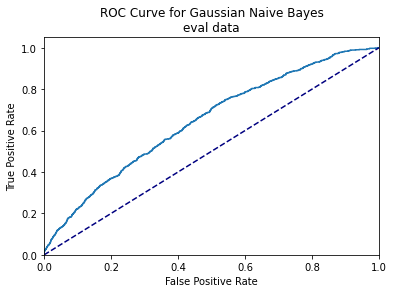

In [41]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve for Gaussian Naive Bayes\neval data")
plt.show()

### Analysis
That did not appear to have much meaningful change. Maybe if we keep going...?

## Simpler Naive Bayes
If we can abstract our information to binary values (or counts, in the case of road types), then we can use a simpler NB model. This might be better, too, because we currently have a mixture of continuous, binary, and "count" input data.

In [42]:
X.iloc[:10, :]

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,...,WT13,WT14,WT15,WT16,WT18,WT19,WT22,cycleway,busy_road,other_roads
2081026,340,31235.682,10.316250,2025.50,0.000127,0.000000,0.417391,46.214286,31.857143,33.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
13892716,158,61315.748,8.181429,1558.00,0.404432,0.000000,0.000000,84.214286,66.928571,70.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
11934664,333,83997.996,11.715000,521.50,0.000260,0.000000,0.000000,45.500000,24.142857,30.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
8636938,172,62606.920,10.065000,1303.50,0.647500,0.000000,0.000000,79.076923,64.928571,68.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4407752,221,57980.122,6.598750,1176.75,0.120588,0.000000,0.000000,85.428571,66.785714,67.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
5865990,17,65366.218,7.510000,102.25,0.000127,0.003636,0.000000,34.785714,23.142857,23.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
17494784,232,52459.352,3.971250,689.75,0.070345,0.000000,0.000000,79.142857,64.214286,65.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
2460723,358,31903.139,7.802500,1185.75,0.000000,0.000000,0.000000,52.928571,31.928571,36.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
22173989,150,68893.034,9.394286,1694.75,0.029540,0.000000,0.000000,78.357143,64.928571,67.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0
8994606,179,72894.548,4.755000,1459.75,0.000000,0.000000,0.000000,90.071429,67.714286,71.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


For starters, let's get a column of the lighting conditions. A more advanced algorithm would lookup the sunrise and sunset and DST and so on, but we will keep it simple for now. Before 6 AM and after 6 PM will be considered "dark"

In [43]:
event_time_hours = X["EVENT_TIME"] / 3600

In [44]:
event_time_hours.head()

2081026      8.676578
13892716    17.032152
11934664    23.332777
8636938     17.390811
4407752     16.105589
Name: EVENT_TIME, dtype: float64

In [45]:
event_time_hours.values

array([ 8.67657833, 17.03215222, 23.33277667, ...,  8.81720222,
       11.81268694, 16.5722175 ])

In [46]:
daylight = pd.Series(
    [1 if _x > 6 and _x < 18 else 0 for _x in event_time_hours.values],
    index=event_time_hours.index
)

In [47]:
daylight.head()

2081026     1
13892716    1
11934664    0
8636938     1
4407752     1
dtype: int64

In [48]:
X["daylight"] = daylight

In [49]:
X.drop(["EVENT_DATE", "EVENT_TIME"], inplace=True, axis=1)

Now, I'm going to ignore wind and add a boolean column for any precipitation

In [50]:
X.drop(["AWND", "PGTM"], inplace=True, axis=1)

In [51]:
prcp_bool = X["PRCP"] > 0
snow_bool = X["SNOW"] > 0
snwd_bool = X["SNWD"] > 0

In [52]:
prcp = (prcp_bool | snow_bool) | snwd_bool 

In [53]:
len(prcp[prcp]) / len(prcp)

0.8485726092828653

That's a lot of precipitation! Oh well...

In [54]:
X["PRCP_ANY"] = prcp.astype(int)

In [55]:
X.drop(["PRCP", "SNOW", "SNWD"], inplace=True, axis=1)

In [56]:
X.head()

,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,...,WT15,WT16,WT18,WT19,WT22,cycleway,busy_road,other_roads,daylight,PRCP_ANY
2081026,46.214286,31.857143,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1,1
13892716,84.214286,66.928571,70.000000,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1,1
11934664,45.500000,24.142857,30.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,1
8636938,79.076923,64.928571,68.500000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,1
4407752,85.428571,66.785714,67.833333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1,1


And, finally, drop temperature. *shrugs*

In [57]:
X.drop(["TMAX", "TMIN", "TOBS"], inplace=True, axis=1)

In [58]:
X.head()

,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,WT11,...,WT15,WT16,WT18,WT19,WT22,cycleway,busy_road,other_roads,daylight,PRCP_ANY
2081026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1,1
13892716,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1,1
11934664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0,1
8636938,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1,1
4407752,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1,1


And now do all this for the eval data

In [59]:
event_time_hours = X_eval["EVENT_TIME"] / 3600

daylight = pd.Series(
    [1 if _x > 6 and _x < 18 else 0 for _x in event_time_hours.values],
    index=event_time_hours.index
)

X_eval["daylight"] = daylight

X_eval.drop(["EVENT_DATE", "EVENT_TIME"], inplace=True, axis=1)

X_eval.drop(["AWND", "PGTM"], inplace=True, axis=1)

prcp_bool = X_eval["PRCP"] > 0
snow_bool = X_eval["SNOW"] > 0
snwd_bool = X_eval["SNWD"] > 0
prcp = (prcp_bool | snow_bool) | snwd_bool 

X_eval["PRCP_ANY"] = prcp.astype(int)
X_eval.drop(["PRCP", "SNOW", "SNWD"], inplace=True, axis=1)
X_eval.drop(["TMAX", "TMIN", "TOBS"], inplace=True, axis=1)

In [60]:
X_eval[:10]

,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,WT11,...,WT15,WT16,WT18,WT19,WT22,cycleway,busy_road,other_roads,daylight,PRCP_ANY
16203066,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0,1
2889199,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0,1
14506408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,1,1
7571704,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0,1
15190919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1,1
1452143,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1,1
21361037,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1,1
17813439,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0,1
367189,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0,1
5462385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1,1


I think we can also combine a lot of these "WTxx", but let's test and come back to that idea

In [61]:
clf = MultinomialNB()
clf.fit(X, y)

MultinomialNB()

In [62]:
y_pred_proba = clf.predict_proba(X_eval)

In [63]:
y_pred = clf.predict(X_eval)

In [64]:
print(roc_auc_score(y, clf.predict_proba(X)[:, 1]))

0.6238286225757796


In [65]:
print(roc_auc_score(y_eval, y_pred_proba[:, 1]))

0.6235615851093175


In [66]:
# [
#     [tn, fp,],
#     [fn, tp]
# ]
confusion_matrix(y_eval, y_pred)

array([[4558288,       0],
       [    707,       0]])

In [67]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba[:, 1])

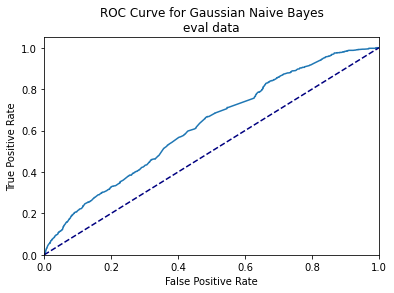

In [68]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve for Gaussian Naive Bayes\neval data")
plt.show()

### Analysis
Ok, that was not better by any stretch. Maybe getting rid of the WTxx columns will help? Or recasting this to be Bernoulli as opposed to multinomial?

Let's start with just ignoring all WTxx columns [*shrugs*]

In [69]:
X = X[["cycleway", "busy_road", "other_roads", "daylight", "PRCP_ANY"]]
X_eval = X_eval[["cycleway", "busy_road", "other_roads", "daylight", "PRCP_ANY"]]

In [70]:
clf = MultinomialNB()
clf.fit(X, y)

MultinomialNB()

In [71]:
y_pred_proba = clf.predict_proba(X_eval)

In [72]:
y_pred = clf.predict(X_eval)

In [73]:
print(roc_auc_score(y, clf.predict_proba(X)[:, 1]))

0.6191401381876991


In [74]:
print(roc_auc_score(y_eval, y_pred_proba[:, 1]))

0.615812473965076


In [75]:
# [
#     [tn, fp,],
#     [fn, tp]
# ]
confusion_matrix(y_eval, y_pred)

array([[4558288,       0],
       [    707,       0]])

In [76]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba[:, 1])

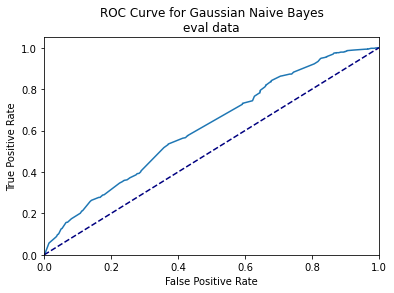

In [77]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve for Gaussian Naive Bayes\neval data")
plt.show()

### Analysis
So far... I appear to be making things worse. Yay...